**Import potrebnih biblioteka i podataka**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
df=pd.read_parquet("btc_historical_price.parquet")

In [4]:
df.head()

,Date,Open,High,Low,Close,Trades,Volume
0,2020-01-01 01:00:00,7189.43,7190.52,7170.15,7171.55,3688.0,2449.049
1,2020-01-01 02:00:00,7171.43,7225.00,7171.10,7210.24,6635.0,3865.038
2,2020-01-01 03:00:00,7210.38,7239.30,7206.46,7237.99,5120.0,3228.365
3,2020-01-01 04:00:00,7237.41,7239.74,7215.00,7221.65,4143.0,2513.307
4,2020-01-01 05:00:00,7221.80,7225.41,7211.22,7213.86,1966.0,1176.666


##**Čišćenje podataka**

Podaci nakon kratke analize izgledaju prilično čisto. Tipovi podataka su točni i nema puno NaN ćelija. NaN sam riješio tako da sam popunio prazne ćelije metodom interpolate, umjesto da stavim nule kako ne bih puno utjecao na konačno predviđanje, s obzirom da se radi o cijenama i količinama koji nisu blizu nule inače.

In [5]:
df.shape

(50676, 7)

In [6]:
df.dtypes

,0
Date,datetime64[ms]
Open,float64
High,float64
Low,float64
Close,float64
Trades,float64
Volume,float64


In [7]:
df.isna().sum()

,0
Date,0
Open,213
High,213
Low,213
Close,213
Trades,213
Volume,213


In [9]:
df=df.sort_values("Date")

In [10]:
duplicates = df[df.duplicated(subset=['Date'])]
print(len(duplicates))

0


##**Početne vizualizacije**

Prikazao sam prvenstveno neke vizualizacije osnovnih podataka, kako bih pokušao naći neke osnovne korelacije za dizajniranje novih značajki.

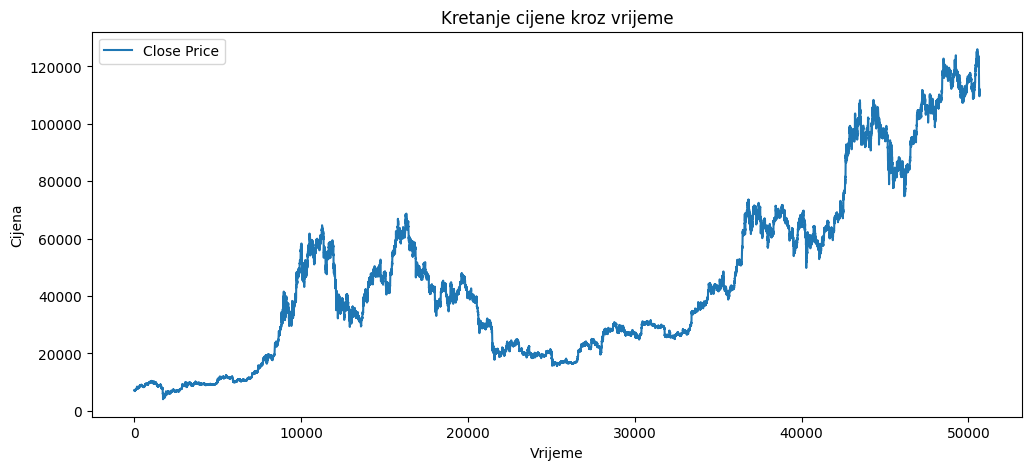

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Close Price")
plt.title("Kretanje cijene kroz vrijeme")
plt.xlabel("Vrijeme")
plt.ylabel("Cijena")
plt.legend()
plt.show()

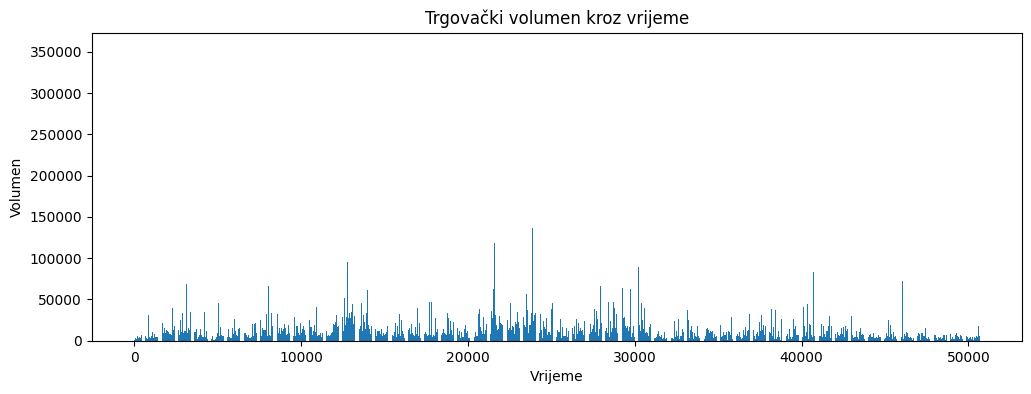

In [12]:
plt.figure(figsize=(12,4))
plt.bar(df.index, df["Volume"])
plt.title("Trgovački volumen kroz vrijeme")
plt.xlabel("Vrijeme")
plt.ylabel("Volumen")
plt.show()

Iz ove dvije vizualizacije možemo doći do prvih zaključaka. Postoji dugoročni rast cijene instrumenta, ali s nerijetkim periodima velikih oscilacija. Također je i volumen nestabilan, te su skokovi često povezani s periodima gdje cijena raste i pada. Na osnovu ovih zaključaka pravim sljedeći graf koji je korelacija između povrata i volumena.

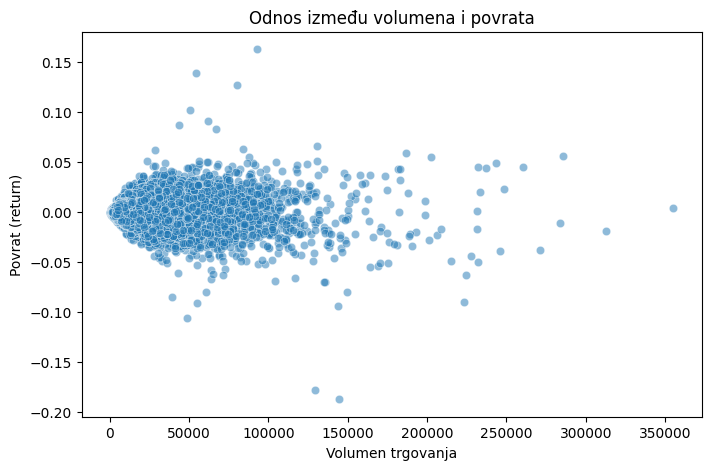

Korelacija između volumena i povrata: -0.040


In [14]:
df["return"]=df["Close"].pct_change()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Volume', y='return', data=df, alpha=0.5)
plt.title("Odnos između volumena i povrata")
plt.xlabel("Volumen trgovanja")
plt.ylabel("Povrat (return)")
plt.show()

corr = df[['Volume', 'return']].corr().iloc[0,1]
print(f"Korelacija između volumena i povrata: {corr:.3f}")

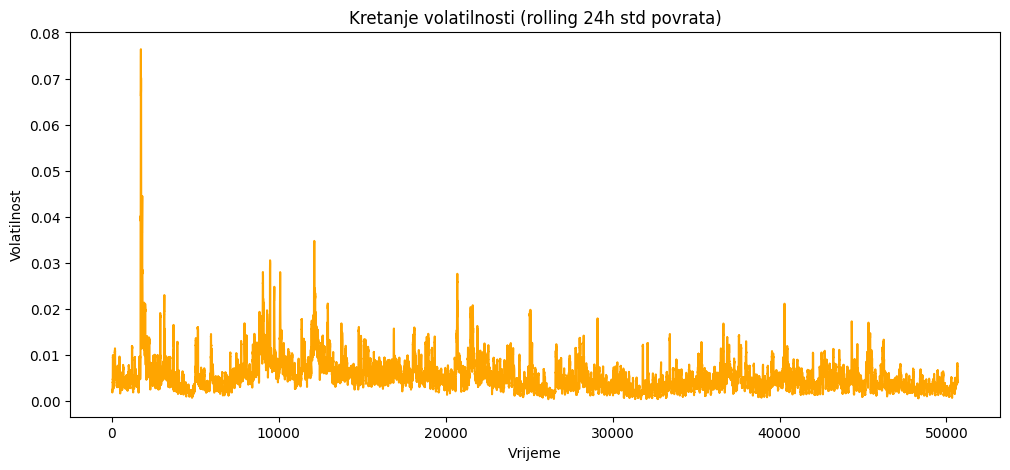

In [15]:
df['volatility_24h'] = df['return'].rolling(24).std()

plt.figure(figsize=(12,5))
plt.plot(df.index, df['volatility_24h'], color='orange')
plt.title("Kretanje volatilnosti (rolling 24h std povrata)")
plt.xlabel("Vrijeme")
plt.ylabel("Volatilnost")
plt.show()

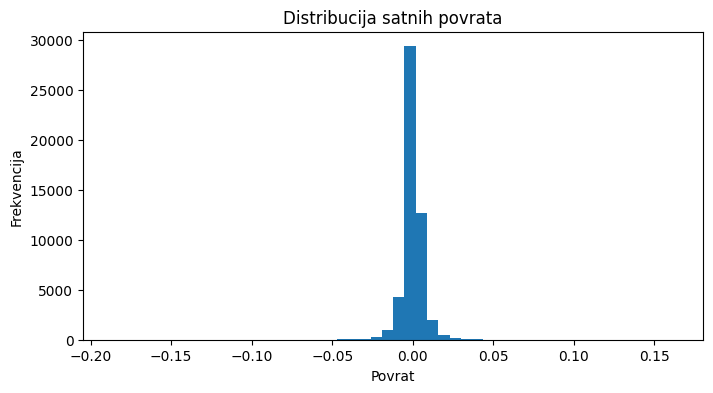

In [16]:
plt.figure(figsize=(8,4))
plt.hist(df["return"].dropna(), bins=50)
plt.title("Distribucija satnih povrata")
plt.xlabel("Povrat")
plt.ylabel("Frekvencija")
plt.show()

**Kreiranje značajki**

Nakon odrađenog osnovnog predprocesiranja podataka i vizualizacija, može se započeti raditi na novim značajkama.
Budući da iz vizualizacija čitamo da postoje jasno vidljivi trendovi, poput pada cijene nakon naglog rasta, pomični prosjeci (EMA i SMA) i momentum bi trebali biti korisni.
Nadalje, periodične faze rasta i pada ukazuju da bi time-based featuri mogli imati smisla.
Iz trgovačkog volumena kroz vrijeme vidimo da bi promjena volumena kroz vrijeme trebala pomoći.
Pošto je većinu vremena tržište mirno, s naglim skokovima, modelu treba neka mjera nemira (volability_10 npr)

Tako da, iskoristit ću većinu značajki ponuđenih u PDF-u zadatka

In [17]:
df["return_t-1"] = df["return"].shift(1)
df["return_t-5"] = df["return"].shift(5)
df["return_t-10"] = df["return"].shift(10)
df["sma_5"] = df["Close"].rolling(5).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["volatility_10"] = df["return"].rolling(10).std()

df["price_ratio"] = df.apply(lambda row: (row["Close"] / row["Open"]) if row["Open"] != 0 else np.nan, axis=1)

df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek

df["volume_avg_10"] = df["Volume"].rolling(10).mean()
df["volume_ratio"] = df.apply(lambda row: (row["Volume"] / row["volume_avg_10"]) if row["volume_avg_10"] != 0 else np.nan, axis=1)
df.drop(columns=["volume_avg_10"], inplace=True)

df["momentum_3"] = df["Close"] - df["Close"].shift(3)
df["momentum_5"]=df["Close"]-df["Close"].shift(5)
df["momentum_10"] = df["Close"] - df["Close"].shift(10)

Lagged features pokazuju što se nedavno dogodilo.

Pokretni prosjeci mi pokazuju dugoročne trendove.

Volatilnost pokazuje koliko cijena oscilira.

Omjeri cijena su odnos unutar istog sata.

Momentum pokazuje koliko se cijena promijenila u odnosu na ranije razdoblje.

In [18]:
df

,Date,Open,High,Low,Close,Trades,Volume,return,volatility_24h,return_t-1,...,sma_20,ema_10,volatility_10,price_ratio,hour,dayofweek,volume_ratio,momentum_3,momentum_5,momentum_10
0,2020-01-01 01:00:00,7189.43,7190.52,7170.15,7171.55,3688.0,2449.049,NaN,NaN,NaN,...,NaN,7171.550000,NaN,0.997513,1,2,NaN,NaN,NaN,NaN
1,2020-01-01 02:00:00,7171.43,7225.00,7171.10,7210.24,6635.0,3865.038,0.005395,NaN,NaN,...,NaN,7178.584545,NaN,1.005412,2,2,NaN,NaN,NaN,NaN
2,2020-01-01 03:00:00,7210.38,7239.30,7206.46,7237.99,5120.0,3228.365,0.003849,NaN,0.005395,...,NaN,7189.385537,NaN,1.003829,3,2,NaN,NaN,NaN,NaN
3,2020-01-01 04:00:00,7237.41,7239.74,7215.00,7221.65,4143.0,2513.307,-0.002258,NaN,0.003849,...,NaN,7195.251803,NaN,0.997822,4,2,NaN,50.10,NaN,NaN
4,2020-01-01 05:00:00,7221.80,7225.41,7211.22,7213.86,1966.0,1176.666,-0.001079,NaN,-0.002258,...,NaN,7198.635112,NaN,0.998901,5,2,NaN,3.62,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50671,2025-10-12 08:00:00,111634.90,111884.80,111433.70,111464.00,98206.0,4420.030,-0.001530,0.004454,-0.000068,...,111201.840,111133.362641,0.004589,0.998469,8,6,0.766029,-22.10,1391.8,631.3
50672,2025-10-12 09:00:00,111463.90,111746.20,111233.00,111244.10,126912.0,5785.539,-0.001973,0.004133,-0.001530,...,111148.065,111153.496706,0.004648,0.998028,9,6,0.969540,-398.30,600.8,265.3
50673,2025-10-12 10:00:00,111244.00,111854.00,111070.40,111772.10,116105.0,4247.260,0.004746,0.004211,-0.001973,...,111126.240,111265.970032,0.004629,1.004747,10,6,0.698506,137.30,286.0,1193.0
50674,2025-10-12 11:00:00,111772.20,111963.90,111377.50,111589.70,105779.0,4056.976,-0.001632,0.004123,0.004746,...,111109.000,111324.830026,0.003273,0.998367,11,6,0.702980,125.70,-52.7,1989.0


##**Predviđanje**

Za biranje modela, testirat ću nekoliko algoritama kako bih pronašao optimalne rezultate.
Gledajući vizualizacije, čisto teoretski, pretpostavio sam da će najbolje rezultate dati modeli koji u obzir uzimaju nelinearnost ovih podataka, odnosno skoro pa nasumičan rast cijene, povrata i volumena prodanog instrumenta.
Testirao sam prvo obični algoritam linearne regresije, iako od njega ne očekivam pozitivne rezultate. Nakon toga, testiramo "ensemble" algoritme.
Usporedit ću rezultate RandomForestRegressor i XGBoost algoritma.
Posljednja vrsta će biti sekvencijski modeli, kako bi iskoristili taj vremenski kontekst podataka. Testirat ćemo LSTM arhitekturu.

In [ ]:
df=df.interpolate(method="linear")

In [26]:
features = [
            "return_t-1", "return_t-5", "return_t-10",
            "sma_5", "sma_20", "ema_10", "volatility_10",
            "volatility_24h", "price_ratio", "hour",
            "dayofweek", "volume_ratio", "momentum_3","momentum_5", "momentum_10"
        ]

df["target"]=df["return"].shift(-1)
df=df.dropna(subset=["return","target"])

target="target"

In [23]:
df_model=df

In [24]:
split_index=int(len(df_model)*0.8)
train=df_model.iloc[:split_index]
test=df_model.iloc[split_index:]

In [25]:
X_train, y_train=train[features], train[target]
X_test, y_test=test[features], test[target]

In [ ]:
df.to_csv("historical_df.csv", index=False)

In [27]:
print(X_train.isna().sum())

return_t-1         1
return_t-5         5
return_t-10       10
sma_5              3
sma_20            18
ema_10             0
volatility_10      9
volatility_24h    23
price_ratio        0
hour               0
dayofweek          0
volume_ratio       8
momentum_3         2
momentum_5         4
momentum_10        9
dtype: int64


In [29]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


In [30]:
model=LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred=model.predict(X_test)

In [32]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

mask = ~np.isnan(y_test) & ~np.isnan(y_pred) & ~np.isinf(y_test) & ~np.isinf(y_pred)
y_test = y_test[mask]
y_pred = y_pred[mask]

In [33]:
mae=mean_absolute_error(y_test,y_pred)
rmse=mean_squared_error(y_test, y_pred)
r2=r2_score(y_test,y_pred)

In [34]:
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


MAE  = 0.003186
RMSE = 0.000024
R²   = -0.0085


Testiranje koje značajke vrijedi zadržati za treniranje modela.

<Axes: >

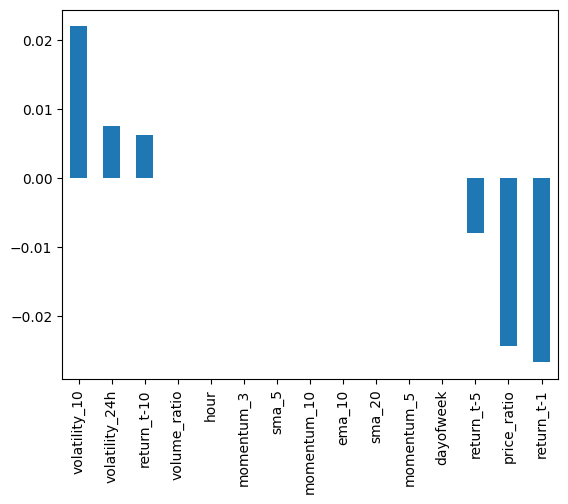

In [35]:
importance = pd.Series(model.coef_, index=X_train.columns)
importance.sort_values(ascending=False).plot(kind='bar')

In [ ]:
#reset

features = [
    "return_t-10",
    "volatility_10","volatility_24h"
]


X_train, y_train=train[features], train[target]
X_test, y_test=test[features], test[target]

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

model=LinearRegression()
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

mask = ~np.isnan(y_test) & ~np.isnan(y_pred) & ~np.isinf(y_test) & ~np.isinf(y_pred)
y_test = y_test[mask]
y_pred = y_pred[mask]

mae=mean_absolute_error(y_test,y_pred)
rmse=mean_squared_error(y_test, y_pred)
r2=r2_score(y_test,y_pred)

print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


MAE  = 0.003164
RMSE = 0.000024
R²   = -0.0000


In [ ]:
joblib.dump(model, "LRmodel.pkl")

['LRmodel.pkl']

Sada imamo bazni model pa na daljima mozemo vidjeti koliko napredujemo.

**Random Forest**

In [ ]:
!pip uninstall sklearn
!pip uninstall scikit-learn
!pip install sklearn


Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/scikit_learn-1.7.2.dist-info/*
    /usr/local/lib/python3.12/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.12/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.7.2
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)


In [38]:
param_grid = {
    "n_estimators": [100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1],
    "bootstrap": [True]
}

grid_search=GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 20],
                         'min_samples_leaf': [1], 'min_samples_split': [2, 5],
                         'n_estimators': [100]})

In [39]:
print("Najbolji parametri:", grid_search.best_params_)
print("Najbolji estimator:", grid_search.best_estimator_)

Najbolji parametri: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Najbolji estimator: RandomForestRegressor(max_depth=10)


In [40]:
RF_model=RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100
)

In [45]:
param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": [10, 20, None],
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(1, 3),
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [46]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c27ee23fd10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c27bfa11940>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c27bf9dc740>},
                   verbose=1)

In [43]:
RF_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5)

In [ ]:
y_pred_RF=RF_model.predict(X_test)

mae=mean_absolute_error(y_test,y_pred_RF)
rmse=np.sqrt(mean_squared_error(y_test, y_pred_RF))
r2=r2_score(y_test,y_pred_RF)


In [ ]:
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


MAE  = 0.003169
RMSE = 0.004861
R²   = -0.0017


In [ ]:
joblib.dump(RF_model, "model.pkl")

['model.pkl']

**XGBoost**

In [ ]:
#reset

df = pd.read_parquet("btc_historical_price.parquet")

df[["Open", "High", "Low", "Close", "Trades", "Volume"]] = (
    df[["Open", "High", "Low", "Close", "Trades", "Volume"]]
    .interpolate(method="linear")
)

df = df.sort_values("Date")

df["return"] = df["Close"].pct_change()
df["volatility_24h"] = df["return"].rolling(24).std()

df["return_t-1"] = df["return"].shift(1)
df["return_t-5"] = df["return"].shift(5)
df["return_t-10"] = df["return"].shift(10)

df["sma_5"] = df["Close"].rolling(5).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()

df["volatility_10"] = df["return"].rolling(10).std()
df["price_ratio"] = df["Close"] / df["Open"]

df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek
df["volume_ratio"] = df["Volume"] / df["Volume"].rolling(10).mean()

df["momentum_3"] = df["Close"] - df["Close"].shift(3)
df["momentum_5"] = df["Close"] - df["Close"].shift(5)
df["momentum_10"] = df["Close"] - df["Close"].shift(10)

df["target"] = df["return"].shift(-1)

features = [
    "return_t-1", "return_t-5", "return_t-10",
    "sma_5", "sma_20", "ema_10",
    "volatility_10", "volatility_24h",
    "price_ratio", "hour", "dayofweek", "volume_ratio",
    "momentum_3", "momentum_5", "momentum_10"
]

df = df.dropna(subset=features + ["target"])

X = df[features]
y = df["target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "reg_alpha":0.3,
    "reg_lambda":1.0,
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.5, 0.5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}

rs = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best XGB params: {'colsample_bytree': np.float64(0.9010984903770198), 'learning_rate': np.float64(0.024910128735954166), 'max_depth': 9, 'n_estimators': 108, 'reg_alpha': np.float64(0.7722447692966574), 'reg_lambda': np.float64(0.1987156815341724), 'subsample': np.float64(0.602208846849441)}


In [ ]:
best_xgb = rs.best_estimator_
y_pred = best_xgb.predict(X_test)

In [ ]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

mask = (
    ~np.isnan(y_test)
    & ~np.isnan(y_pred)
    & ~np.isinf(y_test)
    & ~np.isinf(y_pred)
)
y_test = y_test[mask]
y_pred = y_pred[mask]

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

MAE: 0.003165
RMSE: 0.004859
R²: -0.0006


In [ ]:
joblib.dump(rs, "XGBmodel.pkl")

['XGBmodel.pkl']

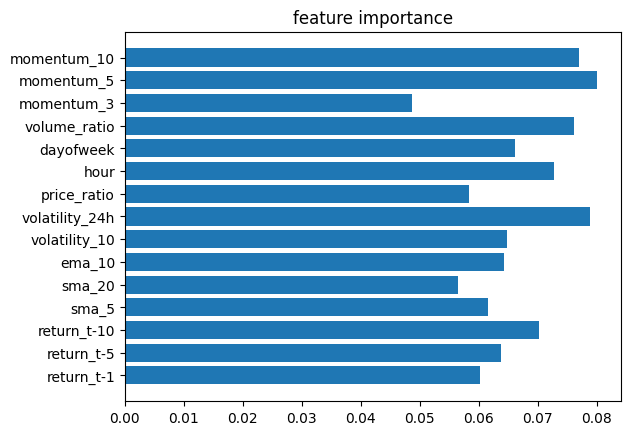

In [ ]:
XGBimportances=rs.best_estimator_.feature_importances_
features=X.columns

plt.barh(features,XGBimportances)
plt.title("Važnost značajki")
plt.show()

**LSTM**

In [ ]:
df_lstm = df.dropna(subset=features + [target]).copy()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_lstm[features])
scaled_target = df_lstm[target].values

In [ ]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 48
X_seq, y_seq = create_sequences(scaled_features, scaled_target, TIME_STEPS)

In [ ]:
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - loss: 0.0141 - val_loss: 0.0083
Epoch 2/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 3/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 4/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 5/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 6/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 7/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 8/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 9/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 10/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 11/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 12

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
MAE: 0.003413
RMSE: 0.005135
R²: -0.1184


In [ ]:
joblib.dump(model, "LSTMmodel.pkl")

##**Stacking**

S obzirom da mi modeli ne daju baš predobre rezultate na evaluacijskim testovima, pokušat ću ih unaprijediti kroz metodu "stackinga".


In [ ]:
lr_features=["return_t-1","return_t-5","price_ratio"]

lr=LinearRegression().fit(X_train[lr_features], y_train)
xgb=XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)

xgb.fit(X_train[features], y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
trainS=pd.DataFrame({
    "lr_pred":lr.predict(X_train[lr_features]),
    "xgb_pred":xgb.predict(X_train[features])
})

testS=pd.DataFrame({
    "lr_pred":lr.predict(X_test[lr_features]),
    "xgb_pred":xgb.predict(X_test[features])
})

r=RidgeCV().fit(trainS,y_train)
y_pred=r.predict(testS)




In [ ]:
print("Stacked MAE:", mean_absolute_error(y_test, y_pred))
print("Stacked RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Stacked R²:", r2_score(y_test, y_pred))

Stacked MAE: 0.0036463358739987945
Stacked RMSE: 0.005467370169245175
Stacked R²: -0.26697660854270744


Bezuspješno. Izgleda da ostajem pri RandomForestRegressor modelu.
Pokušat ću još malo optimizirat značajke i model.

In [ ]:
rf_model=joblib.load(model.pkl)

NameError: name 'model' is not defined

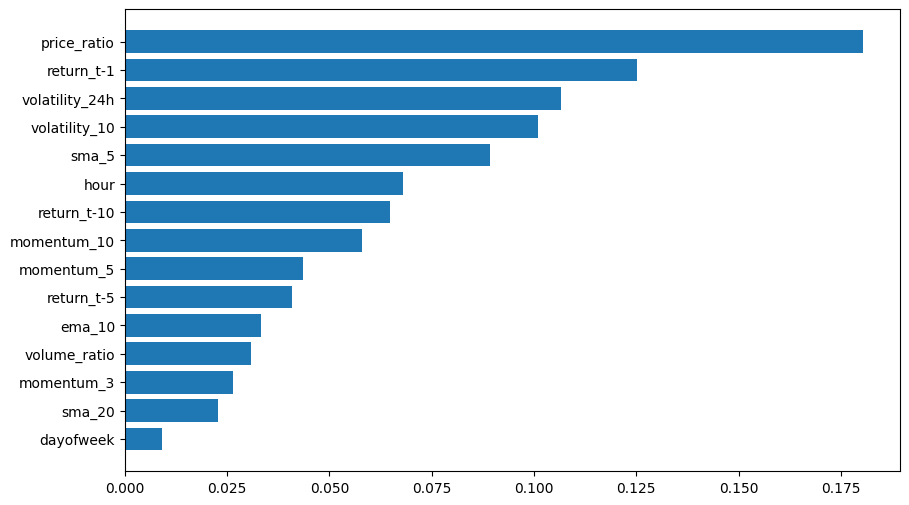

In [ ]:
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.barh(np.array(features)[sorted_idx][:15], importances[sorted_idx][:15])
plt.gca().invert_yaxis()
plt.show()

**Pokušaj dodatne optimizacije RF modela**

In [ ]:
def rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["rsi_14"] = rsi(df["Close"])

In [ ]:
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema12 - ema26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

In [ ]:
sma20 = df["Close"].rolling(20).mean()
std20 = df["Close"].rolling(20).std()
df["bb_upper"] = sma20 + 2 * std20
df["bb_lower"] = sma20 - 2 * std20
df["bb_percent"] = (df["Close"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])


In [ ]:
features=["price_ratio","return_t-1","volatility_24h","volatility_10","sma_5","hour","return_t-10","momentum_10","momentum_5"]

df = df.dropna(subset=features + ["target"])

X = df[features]
y = df["target"]


train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

RF_model=RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)

RF_model.fit(X_train, y_train)

y_pred_RF=RF_model.predict(X_test)

mae=mean_absolute_error(y_test,y_pred_RF)
rmse=np.sqrt(mean_squared_error(y_test, y_pred_RF))
r2=r2_score(y_test,y_pred_RF)


In [ ]:
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")

MAE  = 0.003164
RMSE = 0.004856
R²   = 0.0001


In [ ]:
joblib.dump(RF_model, "rf_model_final.pkl")

['rf_model_final.pkl']